## Notebook to analyze how the LASSO Regression model performs

In [1]:
%load_ext autoreload
%autoreload 1

%aimport dataset_processing
%aimport models
import pandas as pd
import numpy as np
import datetime as dt

training_path = "data/training_dataset.csv"
evaluation_path = "data/evaluation_dataset.csv"
final_evaluation_path = "data/final_evaluation_dataset.csv"

In [2]:
train_df = dataset_processing.generate_dataset(training_path,interval_length=3,
                                               num_past_intervals=15,num_timesteps_whole_network = 0,
                                                 exclude_zero_flows=True, start_time = dt.time(7,30),
                                                 end_time = dt.time(8,30))
test_df = dataset_processing.generate_dataset(evaluation_path,interval_length=3,
                                               num_past_intervals=15, num_timesteps_whole_network = 0,
                                               exclude_zero_flows = True,start_time = dt.time(7,30),
                                                 end_time = dt.time(8,30))

In [ ]:
## Model training
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

y_pred_train = []
y_pred_test = []

DP_ID_values = train_df["DP_ID"].unique()
model_dict = dict.fromkeys(DP_ID_values)

for dp_id in model_dict.keys():
    red_train_df = train_df[train_df["DP_ID"] == dp_id].copy()
    red_test_df = test_df[test_df["DP_ID"] == dp_id].copy()

    interval_features = red_train_df.filter(like="bin_interval_").columns.to_list()
    flow_features = red_train_df.filter(regex=r"^flow_prev").columns.to_list()
    dummy_vars_dow = red_train_df.filter(like="dow_").columns.to_list()

    train_features = train_features = flow_features + dummy_vars_dow + ["is_weekend"] + interval_features
    target = "flow_next_15min"

    X_train = red_train_df[train_features].to_numpy()
    y_train = red_train_df[target].to_numpy()
    X_test = red_test_df[train_features].to_numpy()
    y_test = red_test_df[target].to_numpy()
            
    model = Lasso(alpha=0.1)
    model.fit(X_train,y_train)
    model_dict[dp_id] = model

    y_pred_train.append(model.predict(X_train).ravel())
    y_pred_test.append(model.predict(X_test).ravel())

y_pred_train = np.concatenate(y_pred_train)
y_pred_test = np.concatenate(y_pred_test)

sorted_train_df = train_df.sort_values(by=["DP_ID","datetime"],ascending=True)
sorted_train_df["predicted_flow"] = y_pred_train 

sorted_test_df = test_df.sort_values(by=["DP_ID","datetime"],ascending=True)
sorted_test_df["predicted_flow"] = y_pred_test

In [ ]:
# Calculate base prediction
sorted_test_df["base_prediction"] = (sorted_test_df["flow_prev_0_3_min"] + sorted_test_df["flow_prev_3_6_min"] + \
                              sorted_test_df["flow_prev_6_9_min"] + sorted_test_df["flow_prev_9_12_min"] + \
                              sorted_test_df["flow_prev_12_15_min"])

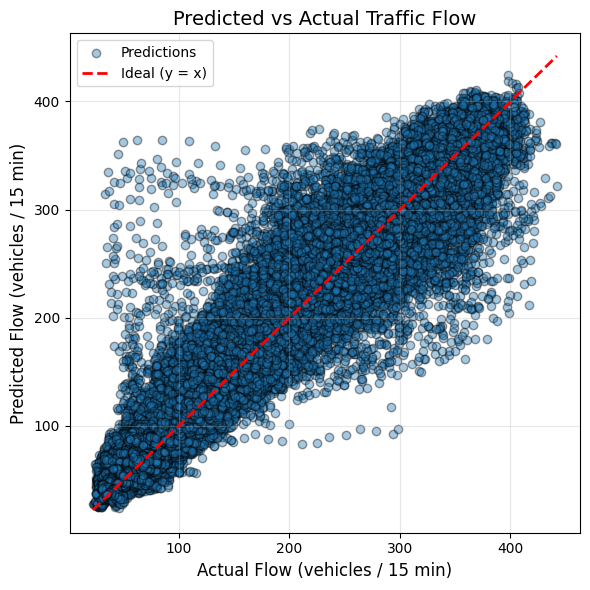

In [ ]:
## Plot actual vs predicted flow for LASSO 
import matplotlib.pyplot as plt

y_true = sorted_test_df["flow_next_15min"]
y_pred = sorted_test_df["predicted_flow"]

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4, edgecolors="k", label="Predictions")

min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Ideal (y = x)")

plt.xlabel("Actual Flow (vehicles / 15 min)", fontsize=12)
plt.ylabel("Predicted Flow (vehicles / 15 min)", fontsize=12)
plt.title("Predicted vs Actual Traffic Flow", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


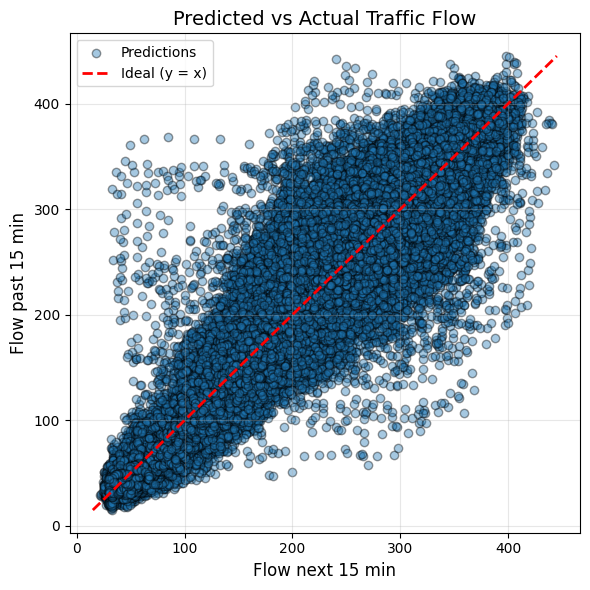

In [ ]:
## Plot actual vs predicted flow for baseline model 

import matplotlib.pyplot as plt

y_true = sorted_test_df["flow_next_15min"]
y_pred = sorted_test_df["base_prediction"]

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4, edgecolors="k", label="Predictions")

min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Ideal (y = x)")

plt.xlabel("Flow next 15 min", fontsize=12)
plt.ylabel("Flow past 15 min", fontsize=12)
plt.title("Predicted vs Actual Traffic Flow", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [15]:
## Analyze difference between predicted and actual values
sorted_test_df["diff_prediction"] = sorted_test_df["predicted_flow"] - sorted_test_df["flow_next_15min"]
sorted_test_df["diff_base_prediction"] = sorted_test_df["base_prediction"] - sorted_test_df["flow_next_15min"]

In [17]:
red_test_df = sorted_test_df[["DP_ID", "portal_order", "datetime", "flow_next_15min", "predicted_flow", "base_prediction", "diff_prediction","diff_base_prediction"]].copy()
red_test_df["perc_difference"] = red_test_df["diff_prediction"] / red_test_df["flow_next_15min"]
red_test_df["perc_base_difference"] = red_test_df["diff_base_prediction"] / red_test_df["flow_next_15min"]
red_test_df

,DP_ID,portal_order,datetime,flow_next_15min,predicted_flow,base_prediction,diff_prediction,diff_base_prediction,perc_difference,perc_base_difference
1485,153,6,2022-01-03 07:30:00,146.0,166.285891,121.0,20.285891,-25.0,0.138944,-0.171233
1486,153,6,2022-01-03 07:31:00,141.0,168.509454,125.0,27.509454,-16.0,0.195103,-0.113475
1487,153,6,2022-01-03 07:32:00,142.0,174.237102,134.0,32.237102,-8.0,0.227022,-0.056338
1488,153,6,2022-01-03 07:33:00,143.0,180.101034,145.0,37.101034,2.0,0.259448,0.013986
1489,153,6,2022-01-03 07:34:00,151.0,174.125432,138.0,23.125432,-13.0,0.153149,-0.086093
...,...,...,...,...,...,...,...,...,...,...
130095,4873,6,2022-06-23 08:26:00,117.0,112.195922,101.0,-4.804078,-16.0,-0.041060,-0.136752
130096,4873,6,2022-06-23 08:27:00,121.0,111.656097,100.0,-9.343903,-21.0,-0.077222,-0.173554
130097,4873,6,2022-06-23 08:28:00,123.0,113.984534,101.0,-9.015466,-22.0,-0.073296,-0.178862
130098,4873,6,2022-06-23 08:29:00,115.0,119.184081,108.0,4.184081,-7.0,0.036383,-0.060870


In [18]:
red_test_df[red_test_df["perc_difference"] > 0.2]

,DP_ID,portal_order,datetime,flow_next_15min,predicted_flow,base_prediction,diff_prediction,diff_base_prediction,perc_difference,perc_base_difference
1487,153,6,2022-01-03 07:32:00,142.0,174.237102,134.0,32.237102,-8.0,0.227022,-0.056338
1488,153,6,2022-01-03 07:33:00,143.0,180.101034,145.0,37.101034,2.0,0.259448,0.013986
1491,153,6,2022-01-03 07:36:00,148.0,178.567224,145.0,30.567224,-3.0,0.206535,-0.020270
1492,153,6,2022-01-03 07:37:00,144.0,182.994008,149.0,38.994008,5.0,0.270792,0.034722
1493,153,6,2022-01-03 07:38:00,138.0,182.959149,151.0,44.959149,13.0,0.325791,0.094203
...,...,...,...,...,...,...,...,...,...,...
130040,4873,6,2022-06-23 07:31:00,98.0,118.435452,90.0,20.435452,-8.0,0.208525,-0.081633
130041,4873,6,2022-06-23 07:32:00,95.0,122.850026,94.0,27.850026,-1.0,0.293158,-0.010526
130080,4873,6,2022-06-23 08:11:00,101.0,125.943458,133.0,24.943458,32.0,0.246965,0.316832
130081,4873,6,2022-06-23 08:12:00,100.0,124.878967,129.0,24.878967,29.0,0.248790,0.290000


### Plot improvement in RMSE per sensor

C:\Users\jemaa\AppData\Local\Temp\ipykernel_24292\2755175180.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({
C:\Users\jemaa\AppData\Local\Temp\ipykernel_24292\2755175180.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


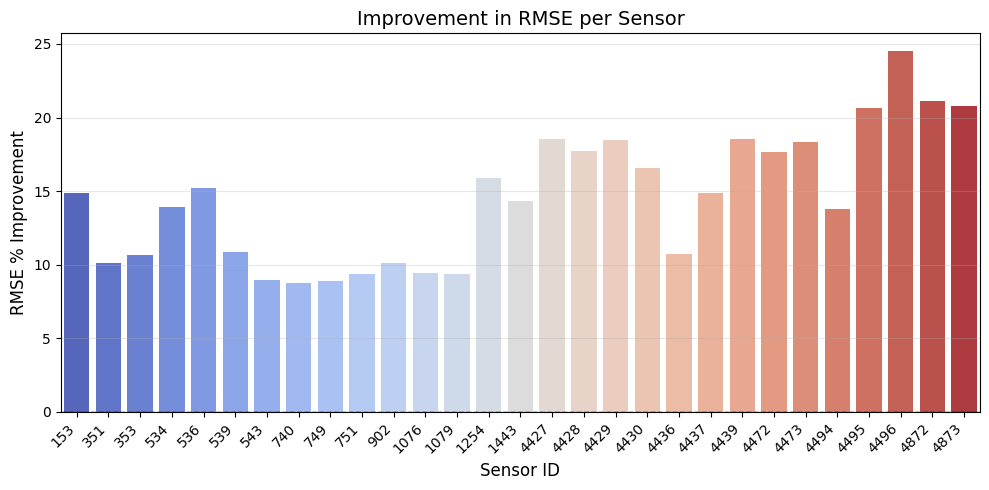

In [ ]:
import seaborn as sns

# Compute RMSE for both model and baseline per sensor
sensor_rmse_comparison = (
    sorted_test_df
    .groupby("DP_ID")
    .apply(lambda df: pd.Series({
        "RMSE_model": np.sqrt(np.mean((df["predicted_flow"] - df["flow_next_15min"])**2)),
        "RMSE_baseline": np.sqrt(np.mean((df["base_prediction"] - df["flow_next_15min"])**2))
    }))
    .reset_index()
)

# Compute improvement (positive = better than baseline)
sensor_rmse_comparison["delta_RMSE"] = sensor_rmse_comparison["RMSE_baseline"] - sensor_rmse_comparison["RMSE_model"]

sensor_rmse_comparison["perc_improvement"] = (sensor_rmse_comparison["delta_RMSE"] / sensor_rmse_comparison["RMSE_baseline"])*100

# Sort by improvement
sensor_rmse_comparison = sensor_rmse_comparison.sort_values(by="perc_improvement", ascending=False)

# Plot improvement
plt.figure(figsize=(10, 5))
sns.barplot(
    data=sensor_rmse_comparison,
    x="DP_ID",
    y="perc_improvement",
    palette="coolwarm",
    hue=None
)

plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.title("Improvement in RMSE per Sensor", fontsize=14)
plt.xlabel("Sensor ID", fontsize=12)
plt.ylabel("RMSE % Improvement", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


### Plot RMSE per day of week

C:\Users\jemaa\AppData\Local\Temp\ipykernel_24292\2045975106.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: np.sqrt(np.mean((df["predicted_flow"] - df["flow_next_15min"])**2)))
C:\Users\jemaa\AppData\Local\Temp\ipykernel_24292\2045975106.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rmse_dow, x="dow", y="RMSE", palette="viridis")


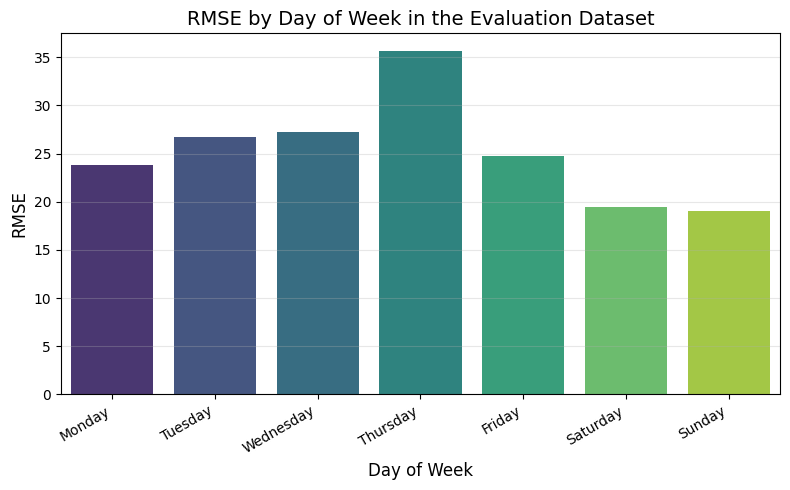

In [ ]:
# Compute RMSE per day of week
rmse_dow = (
    sorted_test_df
    .assign(dow=sorted_test_df["datetime"].dt.day_name())
    .groupby("dow")
    .apply(lambda df: np.sqrt(np.mean((df["predicted_flow"] - df["flow_next_15min"])**2)))
    .reset_index(name="RMSE")
)



# Reorder days of week
dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
rmse_dow["dow"] = pd.Categorical(rmse_dow["dow"], categories=dow_order, ordered=True)
rmse_dow = rmse_dow.sort_values("dow")

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=rmse_dow, x="dow", y="RMSE", palette="viridis")
plt.title("RMSE by Day of Week in the Evaluation Dataset", fontsize=14)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


### Plot RMSE per day of month

C:\Users\jemaa\AppData\Local\Temp\ipykernel_24292\2963629503.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: np.sqrt(np.mean((df["predicted_flow"] - df["flow_next_15min"])**2)))
C:\Users\jemaa\AppData\Local\Temp\ipykernel_24292\2963629503.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rmse_month, x="month", y="RMSE", palette="magma")


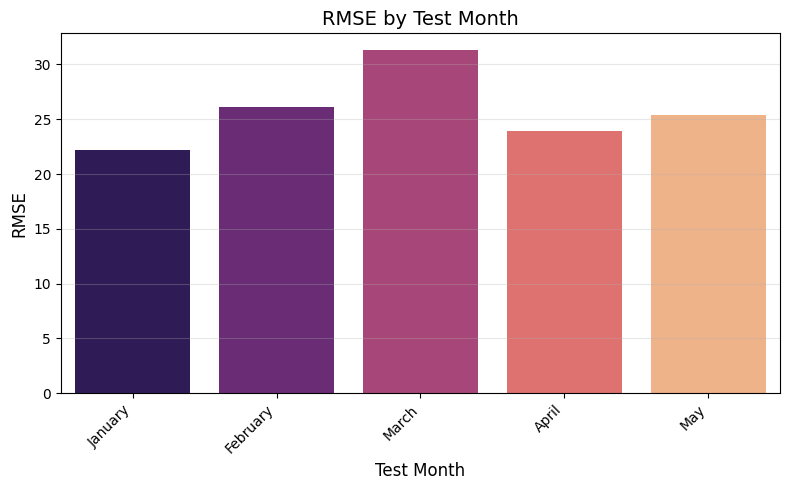

In [33]:
# Compute RMSE per month
rmse_month = (
    sorted_test_df
    .assign(month=sorted_test_df["datetime"].dt.month_name())
    .groupby("month")
    .apply(lambda df: np.sqrt(np.mean((df["predicted_flow"] - df["flow_next_15min"])**2)))
    .reset_index(name="RMSE")
)

# Reorder by calendar month
month_order = [
    "January", "February", "March", "April", "May"
]
rmse_month["month"] = pd.Categorical(rmse_month["month"], categories=month_order, ordered=True)
rmse_month = rmse_month.sort_values("month")

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=rmse_month, x="month", y="RMSE", palette="magma")
plt.title("RMSE by Test Month", fontsize=14)
plt.xlabel("Test Month", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


### Plot MAPE per day of week and month

C:\Users\jemaa\AppData\Local\Temp\ipykernel_24292\2058328364.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: np.mean(np.abs((df["predicted_flow"] - df["flow_next_15min"]) / df["flow_next_15min"])) * 100)
C:\Users\jemaa\AppData\Local\Temp\ipykernel_24292\2058328364.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mape_dow, x="dow", y="MAPE", palette="viridis")


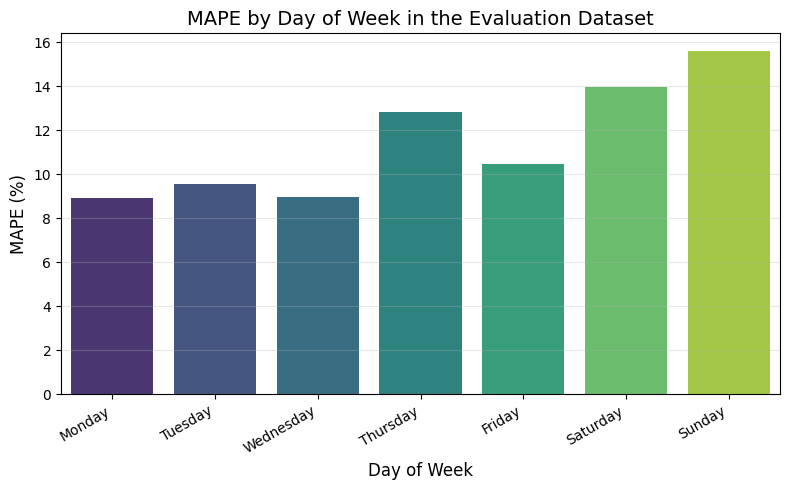

C:\Users\jemaa\AppData\Local\Temp\ipykernel_24292\2058328364.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: np.mean(np.abs((df["predicted_flow"] - df["flow_next_15min"]) / df["flow_next_15min"])) * 100)
C:\Users\jemaa\AppData\Local\Temp\ipykernel_24292\2058328364.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mape_month, x="month", y="MAPE", palette="magma")


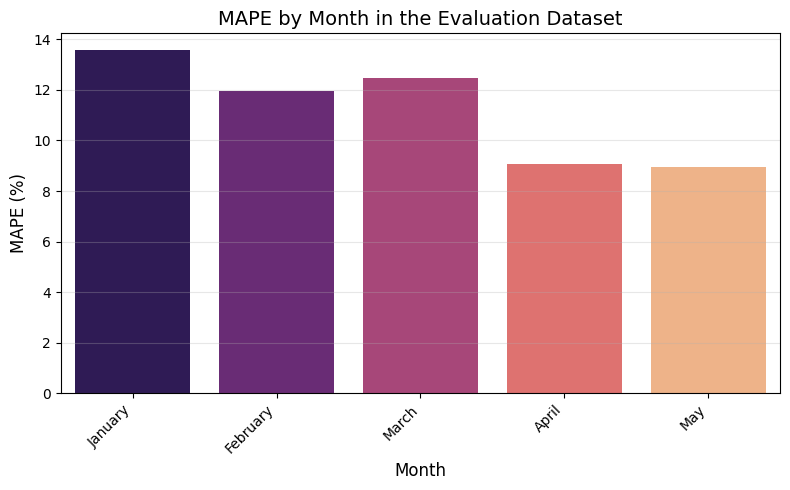

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# MAPE by Day of Week ---
mape_dow = (
    sorted_test_df
    .assign(dow=sorted_test_df["datetime"].dt.day_name())
    .groupby("dow")
    .apply(lambda df: np.mean(np.abs((df["predicted_flow"] - df["flow_next_15min"]) / df["flow_next_15min"])) * 100)
    .reset_index(name="MAPE")
)

# Reorder days of week
dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
mape_dow["dow"] = pd.Categorical(mape_dow["dow"], categories=dow_order, ordered=True)
mape_dow = mape_dow.sort_values("dow")

# Plot MAPE by DOW
plt.figure(figsize=(8,5))
sns.barplot(data=mape_dow, x="dow", y="MAPE", palette="viridis")
plt.title("MAPE by Day of Week in the Evaluation Dataset", fontsize=14)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# MAPE by Month
mape_month = (
    sorted_test_df
    .assign(month=sorted_test_df["datetime"].dt.month_name())
    .groupby("month")
    .apply(lambda df: np.mean(np.abs((df["predicted_flow"] - df["flow_next_15min"]) / df["flow_next_15min"])) * 100)
    .reset_index(name="MAPE")
)

# Reorder months (chronologically)
month_order = ["January", "February", "March", "April", "May"]
mape_month["month"] = pd.Categorical(mape_month["month"], categories=month_order, ordered=True)
mape_month = mape_month.sort_values("month")

# Plot MAPE by Month
plt.figure(figsize=(8,5))
sns.barplot(data=mape_month, x="month", y="MAPE", palette="magma")
plt.title("MAPE by Month in the Evaluation Dataset", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
